## Geospatial Analysis for Airbnb prices in Milano 

**student name : Sanzhar Sailaubek** 

The rapid expansion of short-term rental platforms such as Airbnb has significantly transformed urban housing markets. This study investigates the spatial determinants of Airbnb prices in Milan, Italy, focusing on the role of location and neighborhood characteristics. Specifically, the research examines whether listing prices exhibit spatial patterns and whether proximity to the city center influences price levels.

**Research question**:

**Does proximity to Milan’s city center (Duomo) influence listing prices?**

**I. Data Description**


Airbnb listing data were obtained from InsideAirbnb, which provides publicly accessible snapshots of Airbnb listings for major cities. The dataset includes georeferenced listings in Milan, with detailed attributes such as price, room type, number of reviews, and accommodation characteristics.
Key variables used in this analysis include:
•	Price (in euros)

•	Latitude and longitude

•	Neighborhood identifier

•	Room type

•	Accommodation capacity and bedroom count

•	Number of reviews and rating scores




In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from shapely.geometry import Point


In [4]:
# Load Airbnb listings
listings = pd.read_csv(r"C:\Users\Acer\OneDrive\Desktop\geospatial ds\listings.csv\listings.csv")

# Load neighbourhoods
neigh = gpd.read_file(r"C:\Users\Acer\OneDrive\Desktop\geospatial ds\neighbourhoods.geojson")

listings.head(), neigh.head()


(      id                         listing_url       scrape_id last_scraped  \
 0  23986  https://www.airbnb.com/rooms/23986  20250922033939   2025-09-24   
 1  40470  https://www.airbnb.com/rooms/40470  20250922033939   2025-09-24   
 2  46536  https://www.airbnb.com/rooms/46536  20250922033939   2025-09-24   
 3  84741  https://www.airbnb.com/rooms/84741  20250922033939   2025-09-24   
 4  88130  https://www.airbnb.com/rooms/88130  20250922033939   2025-09-24   
 
             source                                        name  \
 0      city scrape             " Characteristic Milanese flat"   
 1  previous scrape         Giacinto Cosy & clean flat near MM1   
 2      city scrape                 Nico & Cinzia's Pink Suite!   
 3      city scrape             Nice room with private bathroom   
 4      city scrape  Great comfortable & quite APT. x 4 people!   
 
                                          description  \
 0  I look forward to welcoming you in my flat; it...   
 1          

In [5]:
cols = [
    "id",
    "price",
    "latitude",
    "longitude",
    "neighbourhood_cleansed",
    "room_type",
    "property_type",
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms_text",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "review_scores_rating"
]

listings = listings[cols]


In [6]:
# Clean price
listings["price"] = (
    listings["price"]
    .replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Drop missing coordinates or prices
listings = listings.dropna(subset=["price", "latitude", "longitude"])

In [7]:
geometry = [
    Point(xy) for xy in zip(listings.longitude, listings.latitude)
]

gdf = gpd.GeoDataFrame(
    listings,
    geometry=geometry,
    crs="EPSG:4326"
)

neigh = neigh.to_crs("EPSG:4326")

gdf.head()


,id,price,latitude,longitude,neighbourhood_cleansed,room_type,property_type,accommodates,bedrooms,beds,bathrooms_text,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating,geometry
0,23986,180.0,45.448060,9.173730,NAVIGLI,Entire home/apt,Entire rental unit,4,1.0,1.0,1 bath,31,26,0.16,4.64,POINT (9.17373 45.44806)
2,46536,86.0,45.522760,9.224780,VIALE MONZA,Entire home/apt,Entire rental unit,5,2.0,3.0,1 bath,3,39,0.23,4.53,POINT (9.22478 45.52276)
3,84741,36.0,45.469994,9.244106,PARCO FORLANINI - ORTICA,Private room,Private room in loft,2,1.0,1.0,1 private bath,31,690,3.94,4.65,POINT (9.24411 45.46999)
4,88130,250.0,45.497640,9.145330,VILLAPIZZONE,Entire home/apt,Entire rental unit,4,2.0,2.0,2 baths,31,7,0.04,5.00,POINT (9.14533 45.49764)
5,101087,80.0,45.430790,9.182340,STADERA,Entire home/apt,Entire condo,4,3.0,3.0,1 bath,31,9,0.05,4.88,POINT (9.18234 45.43079)


The Airbnb listings dataset was first cleaned and prepared for spatial analysis. Since price values were stored as text including currency symbols and formatting characters, they were converted into numeric format to enable statistical computation.

Currency symbols and thousand separators were removed, and the resulting values were cast to floating-point numbers. Observations with missing price or geographic coordinates were excluded to ensure that all listings included in the analysis were suitable for spatial operations.

To enable geospatial analysis, the tabular dataset was converted into a GeoDataFrame. Each listing was represented as a point geometry constructed from its longitude and latitude coordinates. The coordinate reference system (CRS) was defined as EPSG:4326 (WGS84), which is the standard geographic coordinate system for latitude and longitude.

Finally, neighborhood boundary data were reprojected to the same CRS to ensure spatial compatibility between point and polygon geometries.

This preprocessing step established the foundation for subsequent spatial joins, aggregation, distance computation, and spatial statistical analysis.

In [8]:
gdf.describe()

,id,price,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating
count,2.053800e+04,20538.000000,20538.000000,20538.000000,20538.000000,20526.000000,20506.000000,20538.000000,20538.000000,17646.000000,17646.000000
mean,8.417098e+17,210.899990,45.471582,9.187594,3.391031,1.212901,1.889788,6.811374,44.871604,1.820628,4.710618
std,5.450536e+17,693.894027,0.020605,0.029348,1.562616,0.656704,1.138258,16.150485,90.477565,2.024791,0.414316
min,2.398600e+04,9.000000,45.397080,9.066860,1.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.000000
25%,5.327984e+07,89.000000,45.455223,9.170266,2.000000,1.000000,1.000000,1.000000,2.000000,0.340000,4.630000
50%,1.026108e+18,125.000000,45.471334,9.187992,3.000000,1.000000,2.000000,1.000000,13.000000,1.030000,4.830000
75%,1.305139e+18,190.000000,45.486610,9.209230,4.000000,1.000000,2.000000,2.000000,46.000000,2.600000,4.970000
max,1.514487e+18,65500.000000,45.535420,9.273670,16.000000,10.000000,20.000000,500.000000,1395.000000,14.720000,5.000000


## EDA

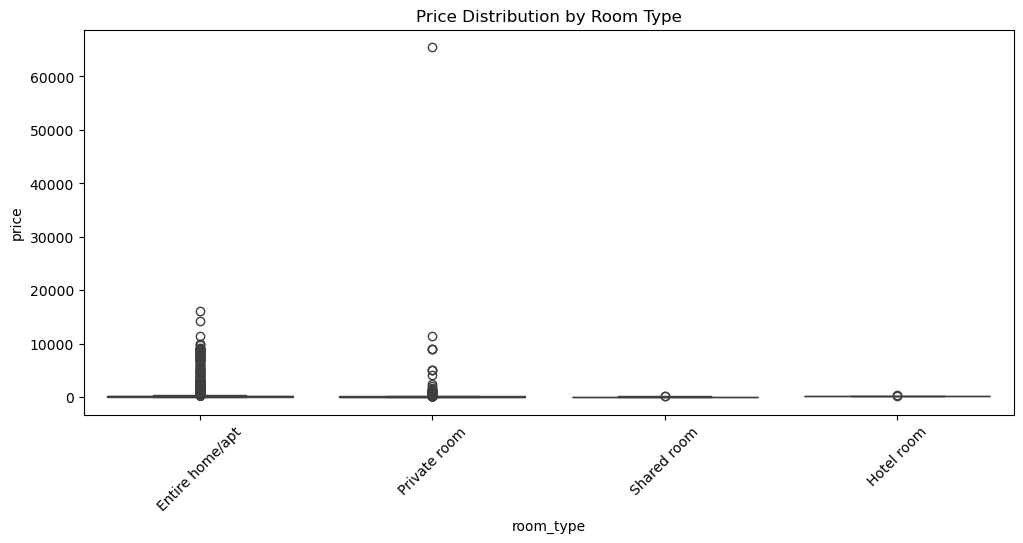

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(x="room_type", y="price", data=gdf)
plt.xticks(rotation=45)
plt.title("Price Distribution by Room Type")
plt.show()


In [18]:
gdf["price"].describe()


count    20538.000000
mean       210.899990
std        693.894027
min          9.000000
25%         89.000000
50%        125.000000
75%        190.000000
max      65500.000000
Name: price, dtype: float64

In [19]:
upper_bound = gdf["price"].quantile(0.99)
upper_bound


np.float64(1200.0)

In [20]:
gdf_clean = gdf[gdf["price"] <= upper_bound].copy()


In [21]:
gdf_clean["price"].describe()


count    20342.000000
mean       168.061990
std        149.970561
min          9.000000
25%         89.000000
50%        124.000000
75%        188.000000
max       1200.000000
Name: price, dtype: float64

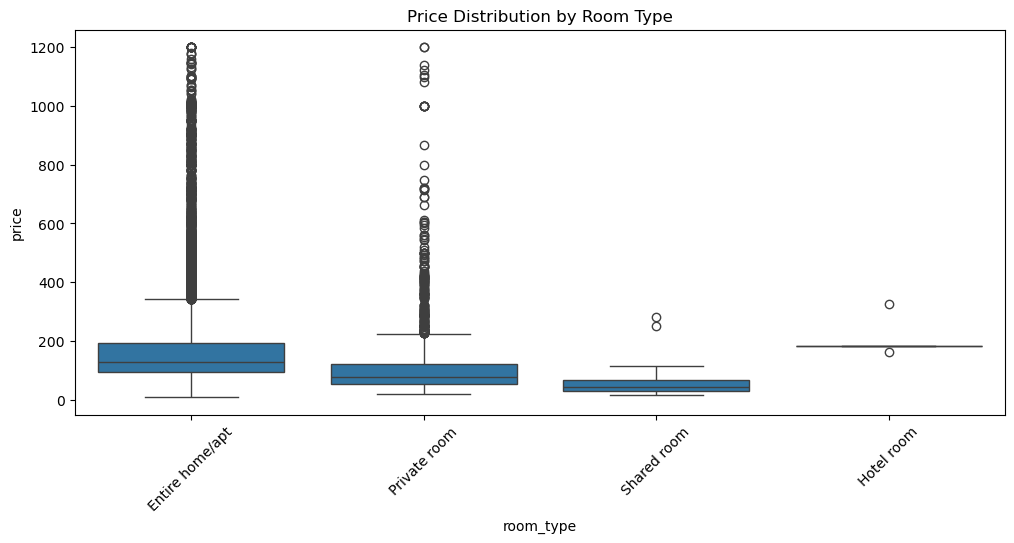

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(x="room_type", y="price", data=gdf_clean)
plt.xticks(rotation=45)
plt.title("Price Distribution by Room Type")
plt.show()


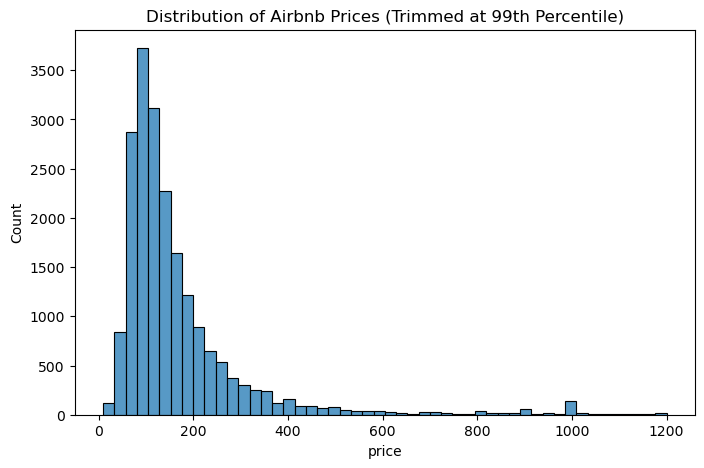

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(gdf_clean["price"], bins=50)
plt.title("Distribution of Airbnb Prices (Trimmed at 99th Percentile)")
plt.show()


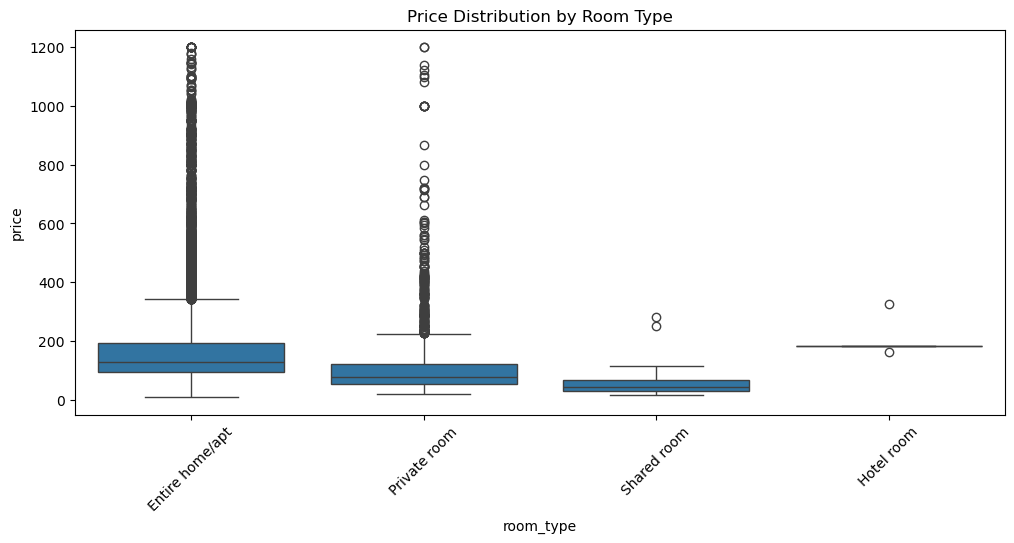

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(x="room_type", y="price", data=gdf_clean)
plt.xticks(rotation=45)
plt.title("Price Distribution by Room Type")
plt.show()


In [25]:
from shapely.geometry import Point

# Project to metric CRS
gdf_projected = gdf_clean.to_crs("EPSG:32632")

# Define Duomo location
duomo = gpd.GeoSeries(
    [Point(9.1916, 45.4642)],
    crs="EPSG:4326"
).to_crs("EPSG:32632")

# Compute distance in km
gdf_projected["distance_km"] = (
    gdf_projected.geometry.distance(duomo.iloc[0]) / 1000
)


In [26]:
gdf_projected["distance_band"] = pd.cut(
    gdf_projected["distance_km"],
    bins=[0,1,3,5,10],
    labels=["0–1 km", "1–3 km", "3–5 km", "5+ km"]
)


<Axes: xlabel='distance_band', ylabel='price'>

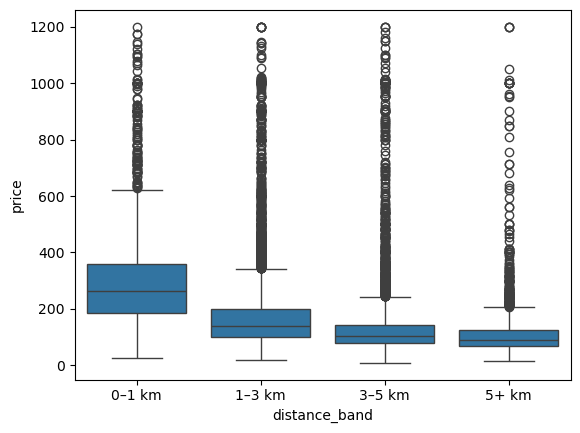

In [27]:
sns.boxplot(x="distance_band", y="price", data=gdf_projected)


<Axes: xlabel='accommodates', ylabel='price'>

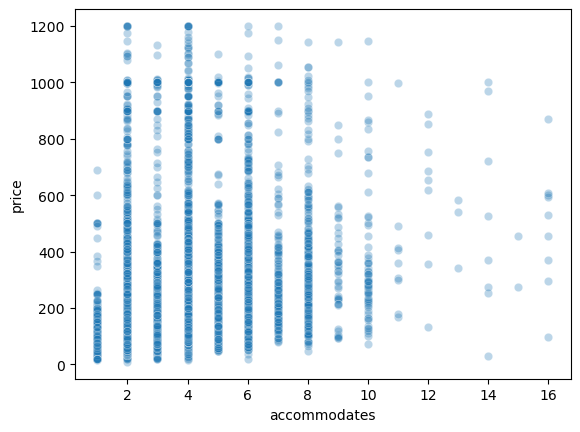

In [28]:
sns.scatterplot(
    x="accommodates",
    y="price",
    data=gdf_clean,
    alpha=0.3
)


In [29]:
gdf_clean.groupby("accommodates")["price"].mean()


accommodates
1      81.958886
2     136.973156
3     151.322514
4     177.314314
5     204.662887
6     251.868841
7     296.566845
8     360.622047
9     366.454545
10    371.234375
11    401.666667
12    599.666667
13    488.000000
14    518.250000
15    365.000000
16    490.444444
Name: price, dtype: float64

In [30]:
gdf_projected[["price", "distance_km", "accommodates"]].corr()


,price,distance_km,accommodates
price,1.000000,-0.269021,0.306823
distance_km,-0.269021,1.000000,-0.044862
accommodates,0.306823,-0.044862,1.000000


# Spatial Join and Choropleth Map

In [31]:
# spatial join

gdf_joined = gpd.sjoin(
    gdf,
    neigh[["neighbourhood", "geometry"]],
    how="left",
    predicate="within"
)

#Aggregate to Neighbourhood Level

neigh_prices = (
    gdf_joined
    .groupby("neighbourhood")
    .agg(
        median_price=("price", "median"),
        listings_count=("price", "count")
    )
    .reset_index()
)

neigh_map = neigh.merge(
    neigh_prices,
    on="neighbourhood",
    how="left"
)

neigh_clean = neigh_map[neigh_map["listings_count"] >= 20].copy()


In [33]:
from libpysal.weights import Queen
from esda.moran import Moran

# reset index so libpysal and pandas match
neigh_clean = neigh_clean.reset_index(drop=True)

# build weights
w = Queen.from_dataframe(neigh_clean, use_index=False)
w.transform = "r"

# identify islands
islands = w.islands

# remove islands by position
neigh_no_islands = neigh_clean.drop(index=islands).reset_index(drop=True)

# rebuild weights
w = Queen.from_dataframe(neigh_no_islands, use_index=False)
w.transform = "r"

# compute Moran's I
mi = Moran(neigh_no_islands["median_price"], w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)


('WARNING: ', 48, ' is an island (no neighbors)')
Moran's I: 0.5990101305869786
p-value: 0.001


C:\Users\Acer\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 48.
  W.__init__(self, neighbors, ids=ids, **kw)


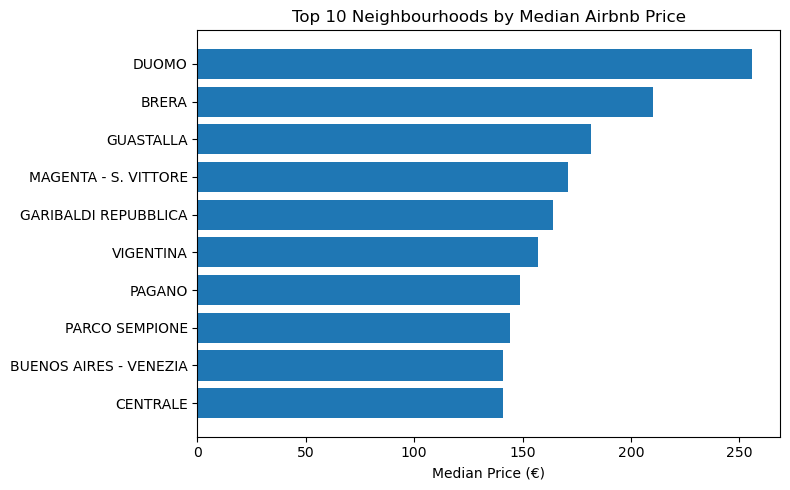

In [34]:
top10 = neigh_no_islands.sort_values(
    "median_price", ascending=False
).head(10)

plt.figure(figsize=(8,5))
plt.barh(top10["neighbourhood"], top10["median_price"])
plt.gca().invert_yaxis()
plt.title("Top 10 Neighbourhoods by Median Airbnb Price")
plt.xlabel("Median Price (€)")
plt.tight_layout()
plt.show()


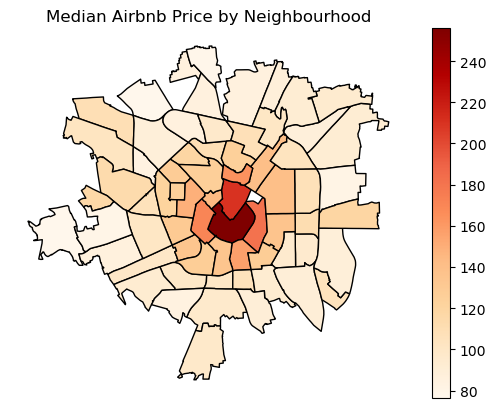

In [35]:
neigh_no_islands.plot(
    column="median_price",
    cmap="OrRd",
    legend=True,
    edgecolor="black"
)

plt.title("Median Airbnb Price by Neighbourhood")
plt.axis("off")
plt.show()


## Regression Model

In [36]:
gdf_projected["price"].corr(gdf_projected["distance_km"])


np.float64(-0.2690206153323018)

In [37]:
import statsmodels.api as sm

X = sm.add_constant(gdf_projected["distance_km"])
y = gdf_projected["price"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1587.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        04:50:17   Log-Likelihood:            -1.3002e+05
No. Observations:               20342   AIC:                         2.600e+05
Df Residuals:                   20340   BIC:                         2.601e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         244.4093      2.168    112.752      

The OLS regression indicates a statistically significant negative relationship between distance from Duomo and Airbnb price.

The coefficient (-25.7) suggests that for each additional kilometer away from the city center, the average listing price decreases by approximately €25.7.

The relationship is statistically significant at conventional levels (p < 0.01).

Although distance from the city center explains a modest proportion of price variation (R² = 0.072), it remains a statistically significant determinant of Airbnb pricing in Milan.

In [38]:
X = gdf_projected[["distance_km", "accommodates"]]
X = sm.add_constant(X)
y = gdf_projected["price"]

model2 = sm.OLS(y, X).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     1929.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        04:50:37   Log-Likelihood:            -1.2902e+05
No. Observations:               20342   AIC:                         2.580e+05
Df Residuals:                   20339   BIC:                         2.581e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          144.0973      3.006     47.939   

Adding accommodation capacity substantially improves explanatory power, increasing R² from 0.072 to 0.159.

In [39]:
import numpy as np

gdf_projected["log_price"] = np.log(gdf_projected["price"])

X = gdf_projected[["distance_km", "accommodates"]]
X = sm.add_constant(X)
y = gdf_projected["log_price"]

model_log = sm.OLS(y, X).fit()
print(model_log.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     4263.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        04:50:53   Log-Likelihood:                -15555.
No. Observations:               20342   AIC:                         3.112e+04
Df Residuals:                   20339   BIC:                         3.114e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8184      0.011    424.003   

The log-linear specification substantially improves model fit (R² = 0.295), indicating that approximately 30% of variation in Airbnb prices is explained by distance from the city center and accommodation capacity.

Each additional kilometer from Duomo is associated with an approximate 14.6% decrease in Airbnb price, holding accommodation capacity constant.

## Interactive Map

In [40]:
gdf_map = gdf_projected.to_crs("EPSG:4326").copy()


In [41]:
m = folium.Map(
    location=[45.4642, 9.19],
    zoom_start=12,
    tiles="cartodbpositron"
)


In [42]:
duomo_group = folium.FeatureGroup(name="Duomo")

folium.Marker(
    location=[45.4642, 9.1916],
    popup="Duomo di Milano",
    icon=folium.Icon(color="red", icon="info-sign")
).add_to(duomo_group)

duomo_group.add_to(m)


In [44]:
import sys
print(sys.version)

import geopandas as gpd
import pandas as pd
import folium
import libpysal
import esda
import statsmodels

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


In [45]:
m

In [47]:
room_types = gdf_map["room_type"].unique()

from branca.colormap import linear

colormap = linear.YlOrRd_09.scale(
    gdf_map["price"].min(),
    gdf_map["price"].max()
)

for room in room_types:
    
    feature_group = folium.FeatureGroup(name=room)
    
    subset = gdf_map[gdf_map["room_type"] == room]
    n_sample = min(len(subset), 1000)
    subset_sample = subset.sample(n_sample, random_state=42)
    
    for _, row in subset_sample.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color=colormap(row.price),
            fill=True,
            fill_opacity=0.7,
            tooltip=f"""
            <b>Price:</b> €{row.price}<br>
            <b>Distance:</b> {round(row.distance_km,2)} km<br>
            <b>Accommodates:</b> {row.accommodates}<br>
            <b>Room Type:</b> {row.room_type}
            """
        ).add_to(feature_group)
    
    feature_group.add_to(m)


In [48]:
colormap.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

m
